In [19]:
source("/root/workspace/code/midas/preprocess/utils.R")
setwd("/root/workspace/code/midas/")
library(RColorBrewer)
library(patchwork)

parser <- ArgumentParser()
parser$add_argument("--reference", type = "character", default = "atlas")
parser$add_argument("--experiment", type = "character", default = "sample_ref")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "sp_00003899")
parser$add_argument("--method", type = "character", default = "midas_embed")
o <- parser$parse_known_args()[[1]]
 

l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

task <- "bm_continual"

In [20]:
# Load configs
config <- parseTOML("configs/data.toml")[[gsub("_continual", "", task)]]
config_ref <- parseTOML("configs/data.toml")[[o$reference]]
query_subset_num <- length(config[["s_joint"]])
config[["raw_data_dirs"]] <- c(config[["raw_data_dirs"]], config_ref[["raw_data_dirs"]])
config[["raw_data_frags"]] <- c(config[["raw_data_frags"]], config_ref[["raw_data_frags"]])
config[["combs"]] <- c(config[["combs"]], config_ref[["combs"]])
config[["comb_ratios"]] <- c(config[["comb_ratios"]], config_ref[["comb_ratios"]])
config[["s_joint"]] <- c(config[["s_joint"]], sapply(X = config_ref[["s_joint"]], FUN = function(x) {x + query_subset_num}))

subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", task)
output_dir <- pj("result", "comparison", task, o$method, o$experiment, o$model, o$init_model)
mkdir(output_dir, remove_old = F)

K <- parseTOML("configs/model.toml")[["default"]]$dim_c

In [21]:
# Load preprossed data
z_list <- list()
cell_name_list <- list()
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    z_dir    <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    z_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
    }
    z_list[[subset_name]] <- bind_rows(z_subset_list)
    
    cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
        "cell_names.csv"), header = T)[, 2]
    
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/30, File 1/136

Loading Subset 1/30, File 2/136

Loading Subset 1/30, File 3/136

Loading Subset 1/30, File 4/136

Loading Subset 1/30, File 5/136

Loading Subset 1/30, File 6/136

Loading Subset 1/30, File 7/136

Loading Subset 1/30, File 8/136

Loading Subset 1/30, File 9/136

Loading Subset 1/30, File 10/136

Loading Subset 1/30, File 11/136

Loading Subset 1/30, File 12/136

Loading Subset 1/30, File 13/136

Loading Subset 1/30, File 14/136

Loading Subset 1/30, File 15/136

Loading Subset 1/30, File 16/136

Loading Subset 1/30, File 17/136

Loading Subset 1/30, File 18/136

Loading Subset 1/30, File 19/136

Loading Subset 1/30, File 20/136

Loading Subset 1/30, File 21/136

Loading Subset 1/30, File 22/136

Loading Subset 1/30, File 23/136

Loading Subset 1/30, File 24/136

Loading Subset 1/30, File 25/136

Loading Subset 1/30, File 26/136

Loading Subset 1/30, File 27/136

Loading Subset 1/30, File 28/136

Loading Subset 1/30, File 29/136

Loading Subset 1/30, Fi

In [ ]:
# Create seurat object
rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
colnames(rna) <- do.call("c", unname(cell_name_list))
rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
obj <- CreateSeuratObject(counts = rna, assay = "rna")

z <- data.matrix(bind_rows(z_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj)
obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

obj

In [ ]:
# Generate UMAP for visualization
obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
SaveH5Seurat(obj, pj(output_dir, "obj.h5seurat"), overwrite = TRUE)
# obj <- LoadH5Seurat(pj(output_dir, "obj.h5seurat"), reductions = "c.umap")

01:44:30 Writing NN index file to temp file /tmp/RtmpgMyCzL/file1a4483e5ffb9

01:44:30 Searching Annoy index using 64 threads, search_k = 3000

01:44:35 Annoy recall = 100%

01:44:36 Commencing smooth kNN distance calibration using 64 threads
 with target n_neighbors = 30

01:44:47 Initializing from normalized Laplacian + noise (using irlba)

01:45:07 Commencing optimization for 200 epochs, with 11376996 positive edges

01:47:25 Optimization finished

Warning message:
"Overwriting previous file result/comparison/bm_continual/midas_embed/sample_ref/default/sp_00003899/obj.h5seurat"
Creating h5Seurat file for version 3.1.5.9900

Adding counts for rna

Adding data for rna

No variable features found for rna

No feature-level metadata found for rna

Adding cell embeddings for c

No loadings for c

No projected loadings for c

No standard deviations for c

No JackStraw data for c

Adding cell embeddings for c.umap

No loadings for c.umap

No projected loadings for c.umap

No standard deviat

In [63]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[1:query_subset_num]

cell_label <- gsub(" cell", "", read.csv(pj(output_dir, "label_gt.csv"), header = F)[, 1])
obj@meta.data$highlight[select_mask] <- cell_label

# Set colors
cell_label_unique <- unique(cell_label)
labels <- str_sort(cell_label_unique)

# col_8 <- c("#8FC36D", "#f54646", "#4472c4", "#ff00ff", "#82B4ed", "#D4aaff", "#008000", "#fff300")
col_8 <- c("#8FC36D", "#f54646", "#4472c4", "#ff69b4", "#fff300", "#008000", "#ad6800", "#0000ff")

pal <- col_8
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")


# plot
p1 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = T, raster_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 0.1, 
              shuffle = F, cols = cols, legend = T, return_plt = T, save_path = pj(output_dir, paste(task,
              o$method, o$experiment, o$model, o$init_model, "c_merged_label_l1", sep = "_"))) +
    labs(colour = "Seurat ell type")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



In [ ]:
cell_label <- gsub(" cells", "", read.csv(pj(output_dir, "label_transferred.csv"), header = F)[, 1])
obj@meta.data$highlight[select_mask] <- cell_label

# Set colors
cell_label_unique <- unique(cell_label)
labels <- str_sort(cell_label_unique)

col_13 <- c("#8FC36D", "#f54646", "#ff00ff", "#4472c4", "#82B4ed",  "#ff69b4", "#14e6e6", "#D4aaff", "#fff300", "#008000", "#eee8aa", "#2f4f4f", "#ad6800")

pal <- c(col_13, "#0000ff")
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")

# plot
p2 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = T, raster_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 0.1, 
              shuffle = F, cols = cols, legend = T, return_plt = T, save_path = pj(output_dir, paste(task,
              o$method, o$experiment, o$model, o$init_model, "c_merged_label_transfer", sep = "_"))) +
    labs(colour = "MIDAS cell type")


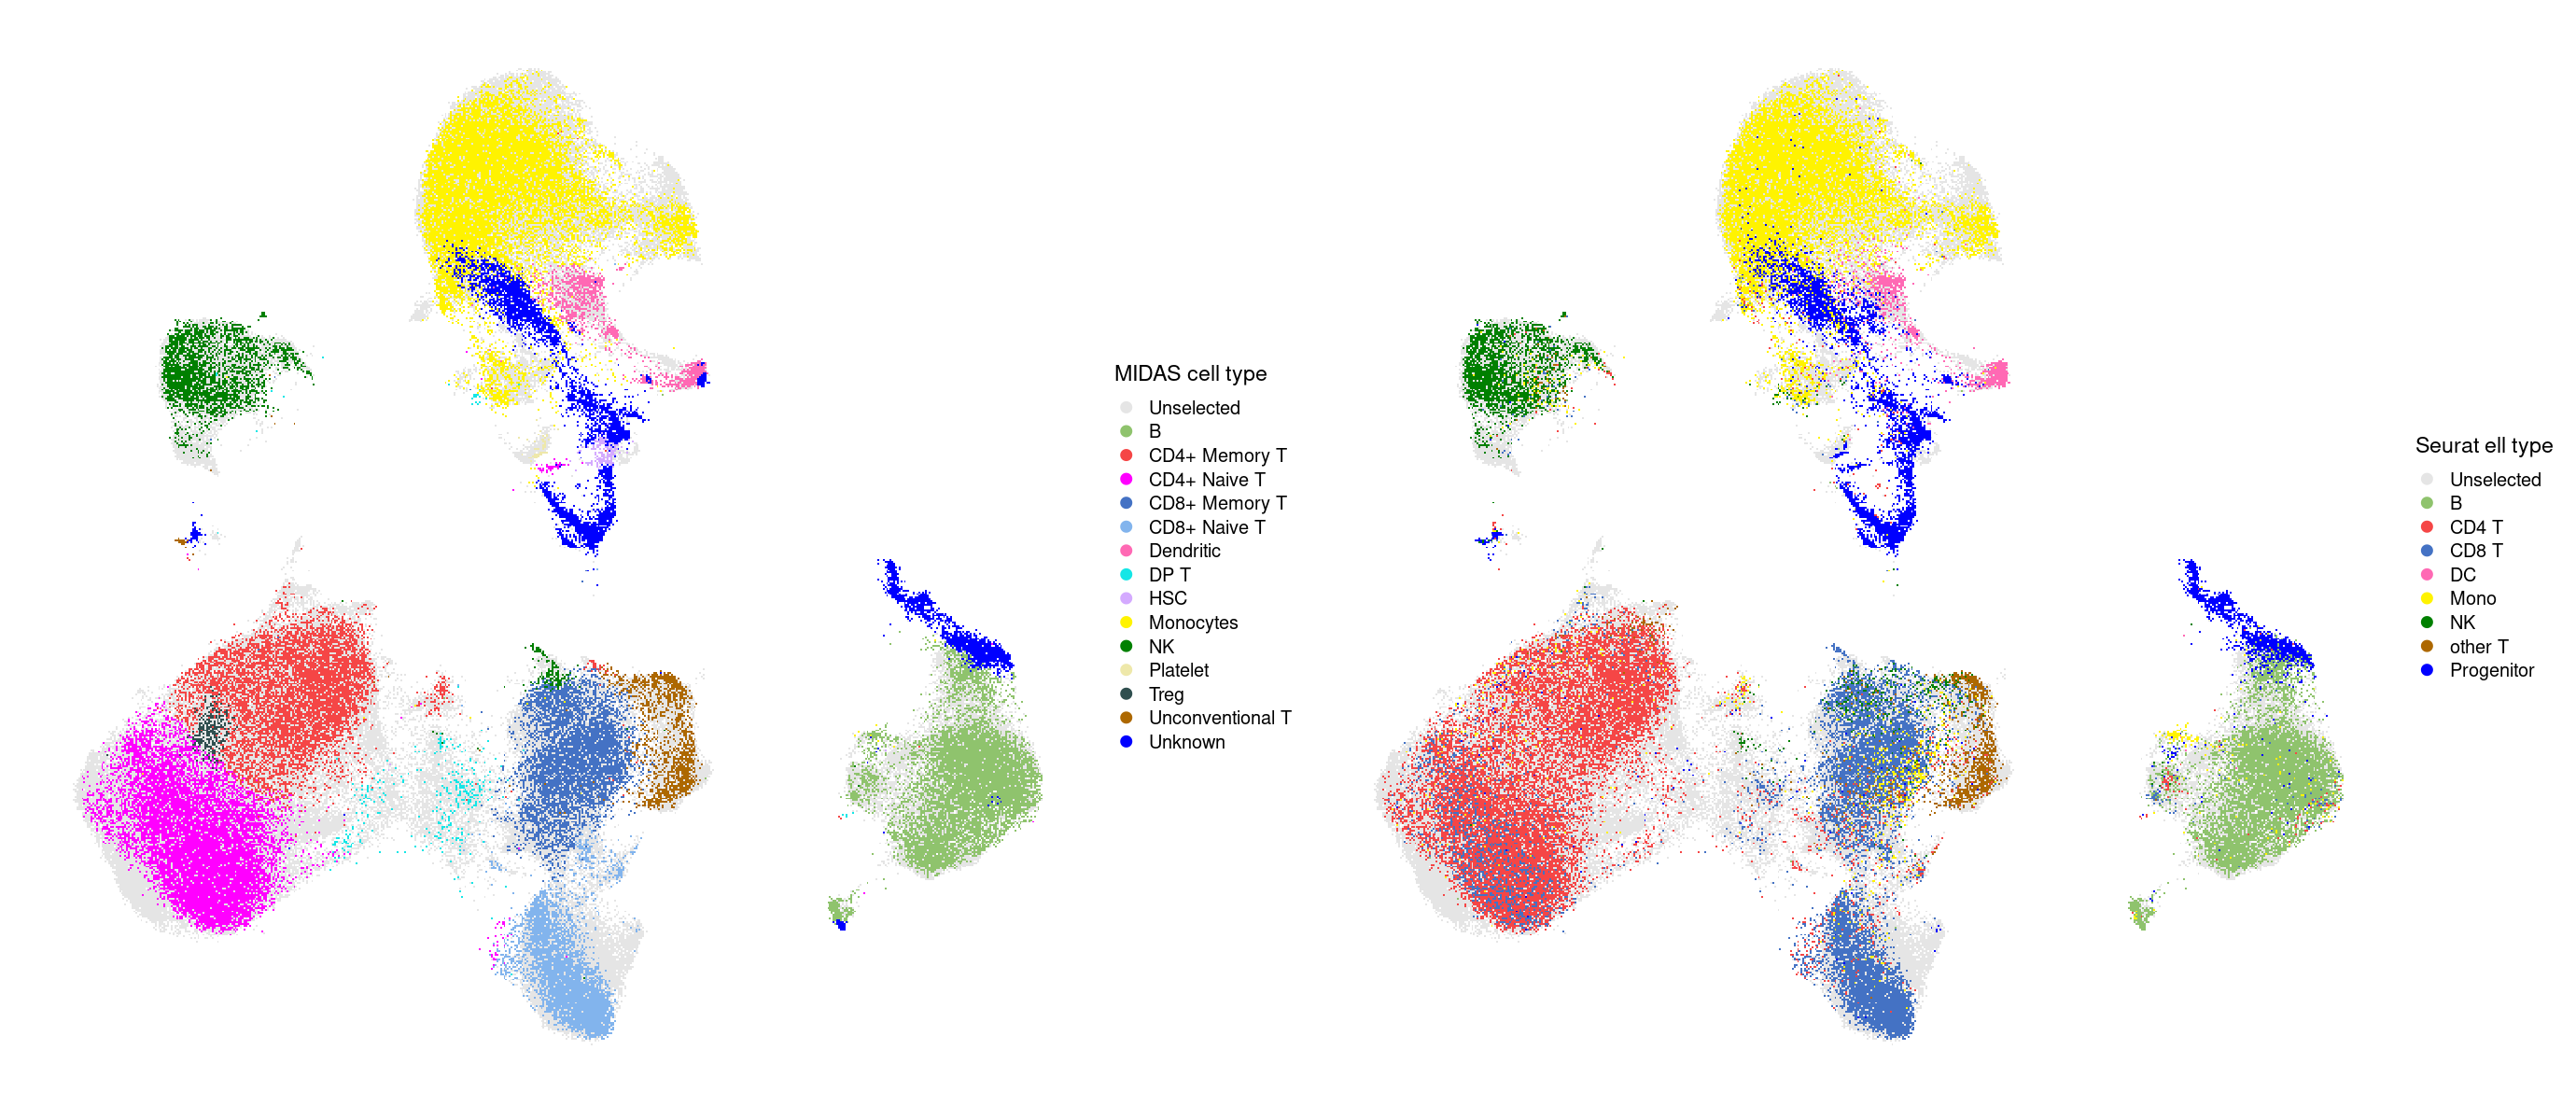

In [71]:
w = 2 * (L + 1.5)
h = L
plt_size(w, h)
plt <- p2 + p1 
plt

In [72]:
save_dir <- "paper/6"
mkdir(save_dir, remove_old = F)
ggsave(plot = plt, file = pj(save_dir, "6_label_transfer_bm_umap.png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = pj(save_dir, "6_label_transfer_bm_umap.pdf"), width = w, height = h, limitsize = F)